# Importing Packages

In [1]:
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc import types, fft, waveform
import lal
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from matplotlib import ticker

import matplotlib.pyplot as plt

# Importing $(l, m)=(2, 2)$ analytical model notebook 

In [2]:
%run Model_22_Updated.ipynb  

In [3]:
def intp(t,h):   
    delta_t  = 1/4096
    #### interpolation to sample data at equispaced time points
    tVec_NR_int = np.linspace(t[0],t[-1],int(abs(t[-1]-t[0])/delta_t)) 
    hp_NR_sample = interp1d(t,h,kind='cubic')
    hp_NR_int = hp_NR_sample(tVec_NR_int)
    
    return(tVec_NR_int,hp_NR_int)

# Dominant mode model v/s $(2, 2)$ mode hybrids Match

# $(2, 2)$ mode EOB vs $(2, 2)$ mode hybrids Match

In [4]:
L=5


def freq(j):
    return(xlow**(3/2)/(j*MTSUN_SI*math.pi))


def loop(angle): #loop(angle,appx)
    
    mass_array=[]
    match_array=[]
    mismatch_array=[]
    
    theta=angle
    
    L=5
    for l in range(1,L+1):
        
        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            globals()['sph' + str(l) + str(m)] = Ylm
    
    
    hpVec=(sph22*hpl2m2Vec)         
    tVec_NR=tl2m2Vec
    
    
    for i in tqdm(range(35,201,5)):    
        M1=i*q/(q+1)
        M2=i/(q+1)
        M=i
        M_SI=M*MSUN_SI
        D_SI=(10**(6))*PC_SI
        tVec_SI=tVec_NR*M*MTSUN_SI;
        hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI;
        delta_t_NR=np.mean(np.diff(tVec_SI))
        
        mergIdx=np.argmax(hpVec_SI)
        tVec_SI_shifted=tVec_SI-tVec_SI[mergIdx]
        
    
        hpVec_SI = TimeSeries(hpVec_SI, delta_t=delta_t_NR, epoch=-delta_t_NR*mergIdx) 
        
        
        xmin = xconv(f,30)
        flow = fconv(xmin,i)
            
        #Turn on the next line when EOB is needed
        #hp, hc= get_td_waveform(approximant=appx,
                                 #mass1=M1,
                                 #mass2=M2,
                                 #delta_t=delta_t_NR,
                                 #f_lower=flow,
                                 #distance=1,inclination=theta)
        
        #Turn on the next line when dominant mode model is needed
        hp, hc = eccmodel(M,q,e,li,flow,inclination=theta,d=1,delta_t=delta_t_NR) #edit = commented
       
    
        sp=hpVec_SI
        # Resize the waveforms to the same length
        tlen = max(len(sp), len(hp))
        sp.resize(tlen)
        hp.resize(tlen)
        
        # Generate the aLIGO ZDHP PSD
        delta_f = 1.0 / sp.duration 
        flen = tlen//2 + 1
        f_low = 20 #flow
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        # Note: This takes a while the first time as an FFT plan is generated
        # subsequent calls are much faster.
        m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
        mismatch=1-m
    
    
        mass_array.append(M)
        match_array.append(m)
        mismatch_array.append(mismatch)
        
    return (mass_array,mismatch_array)

# List of Hybrids and Parameters 

In [5]:

hyb = ['1355','1356','1358','1359','1360','1361','1364','1365','1366','1367','1368','1372','1373']
#hyb = ['1355','1356','1357','1358','1359','1360','1361','1362','1363','1364','1365','1366','1367','1368','1369','1370','1371','1372','1373','1374']
#hyb = ['1357','1362','1363','1369','1370','1371','1374']
 
q0 = [1,1,1,1,1,1,2,2,2,2,2,3,3]
#q0 = [1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3]
#q0 = [1,1,1,2,2,3,3]

l0 = [1.423,1.574,-2.682,1.834,-0.395,-1.019,-0.181,-1.127,-2.890,1.687,0.420,3.005,1.682]
#l0 = [1.423,1.574,0.451,-2.682,1.834,-0.395,-1.019,-0.507,-0.912,-0.181,-1.127,-2.890,1.687,0.420,-0.203,3.063,0.665,3.005,1.682,3.114]
#l0 = [0.451,-0.507,-0.912,-0.203,3.063,0.142,3.114]

e0 = [0.173, 0.230, 0.322, 0.317, 0.416, 0.416, 0.172, 0.209, 0.320, 0.320, 0.324, 0.300, 0.300]
#e0 = [0.173, 0.230, 0.322, 0.322, 0.317, 0.416, 0.416, 0.483, 0.505, 0.172, 0.209, 0.320, 0.320, 0.324, 0.478, 0.508, 0.204, 0.300, 0.300, 0.495]
#e0 = [0.322,0.483,0.505,0.478,0.508,0.204,0.495]

f0 = [16.53, 15.63, 13.51, 13.92, 12.18, 11.95, 16.68, 15.72, 13.76, 13.84, 13.36, 13.75, 13.74]
#f0 = [16.53, 15.63, 13.74, 13.51, 13.92, 12.18, 11.95, 12.78, 11.62, 16.68, 15.72, 13.76, 13.84, 13.36, 12.87, 10.69, 15.94, 13.75, 13.74, 10.62]
#f0 = [13.74,12.78,11.62,12.87,10.69,15.94,10.62]

print(len(hyb),len(q0),len(l0),len(e0),len(f0))


13 13 13 13 13


# Choose Approximant and Inclination

In [6]:
appx='SEOBNRv4'
inc = 0
print(inc)

0


# Match Calculations 

In [7]:
for i in range(0,len(hyb)):
    hname = hyb[i]
    q = q0[i]
    e = e0[i]
    li = l0[i]
    f = f0[i]
    
    hfile = [hname+'_EccTD_22_hyb_poster.h5']
    
    #hf=h5py.File('/home/croyt/GW_codes/match_circvsHMhyb/'+hfile[0],'r')
    hf=h5py.File('/home/pratul/Downloads/Project/New hybrids/'+hfile[0],'r')
    data = hf['l2_m2']
    tl2m2Vec = np.real(data[:,0])
    hpl2m2Vec = np.real(data[:,1])

    
        
    
    
    Mtot,globals()['match' + str(hname)] = loop(inc)

100%|███████████████████████████████████████████| 34/34 [01:03<00:00,  1.85s/it]


# Plot settings

In [8]:
estr = [0.173, 0.230, 0.322, 0.317, 0.416, 0.416, 0.172, 0.209, 0.320, 0.320, 0.324, 0.300, 0.300]
#estr=[0.173, 0.230, 0.322, 0.322, 0.317, 0.416, 0.416, 0.483, 0.505, 0.172, 0.209, 0.320, 0.320, 0.324, 0.478, 0.508, 0.204, 0.300, 0.300, 0.495]
#estr = [0.322,0.483,0.505,0.478,0.508,0.204,0.495]

In [9]:
tick = np.linspace(0.1,0.5,7)  
tick = np.linspace(0.1,0.5,11)
tick = np.around(tick,decimals=2)

In [10]:
import matplotlib.pyplot as mpl
from matplotlib.ticker import LogFormatter
from matplotlib import rc

In [11]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14, direction='in') 
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1

/home/pratul/anaconda3/envs/pycbc/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


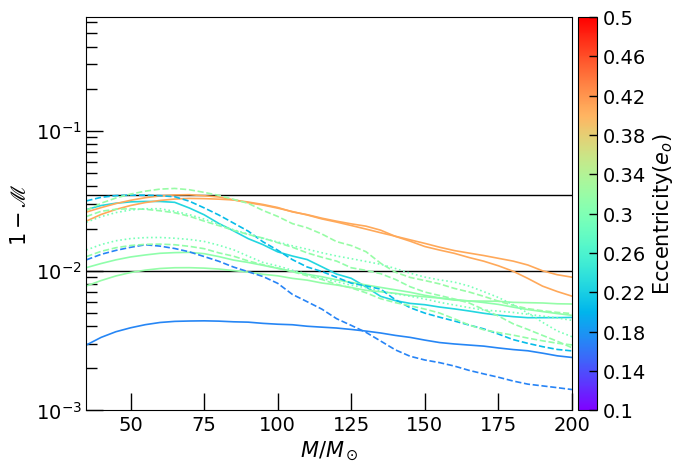

In [14]:
plt.figure(figsize=(7,5)) 
binl = 0.001
N = int((0.51-0.1)/binl)
cmap = plt.get_cmap('rainbow', N)
sm = plt.cm.ScalarMappable(cmap=cmap)
lw = [2,0.8,1.2,1.5]
lsty=['-','--',':']

plt.axhline(y = 1-0.965, color = 'k', linestyle = '-',linewidth = 1)
plt.axhline(y = 1-0.99, color = 'k', linestyle = '-',linewidth = 1)
#'''
plt.plot(Mtot,np.array(match1355),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[0]-0.1)/binl)))
plt.plot(Mtot,np.array(match1356),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[1]-0.1)/binl)))
#plt.plot(Mtot,np.array(match1357),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[2]-0.1)/binl)))
plt.plot(Mtot,np.array(match1358),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[2]-0.1)/binl)))
plt.plot(Mtot,np.array(match1359),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[3]-0.1)/binl)))
plt.plot(Mtot,np.array(match1360),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[4]-0.1)/binl)))
plt.plot(Mtot,np.array(match1361),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[5]-0.1)/binl)))
#plt.plot(Mtot,np.array(match1362),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[7]-0.1)/binl)))
#plt.plot(Mtot,np.array(match1363),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[8]-0.1)/binl)))

plt.plot(Mtot,np.array(match1364),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[6]-0.1)/binl)))
plt.plot(Mtot,np.array(match1365),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[7]-0.1)/binl)))
plt.plot(Mtot,np.array(match1366),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[8]-0.1)/binl)))
plt.plot(Mtot,np.array(match1367),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[9]-0.1)/binl)))
plt.plot(Mtot,np.array(match1368),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[10]-0.1)/binl)))
#plt.plot(Mtot,np.array(match1369),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[14]-0.1)/binl)))
#plt.plot(Mtot,np.array(match1370),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[15]-0.1)/binl)))

#plt.plot(Mtot,np.array(match1371),linestyle=lsty[2],linewidth = lw[2],c=cmap(int((estr[16]-0.1)/binl)))
plt.plot(Mtot,np.array(match1372),linestyle=lsty[2],linewidth = lw[2],c=cmap(int((estr[11]-0.1)/binl)))
plt.plot(Mtot,np.array(match1373),linestyle=lsty[2],linewidth = lw[2],c=cmap(int((estr[12]-0.1)/binl)))
#plt.plot(Mtot,np.array(match1374),linestyle=lsty[2],linewidth = lw[2],c=cmap(int((estr[19]-0.1)/binl)))





cbar = plt.colorbar(sm,pad=0.01)
tick_locator = ticker.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.ax.set_yticklabels(tick)
cbar.set_label(label='Eccentricity$(e_o)$',size=15)
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=3, direction = 'in')
cbar.ax.tick_params(which="major",width=1, length=6, direction = 'in')

#plt.title(r'$\iota = 0$', fontsize = 15, loc = 'center')
plt.ylim(ymax=6.5e-1)
plt.ylim(ymin=4e-4)
plt.ylim(ymin=1e-3)
plt.xlim(xmin=35)
plt.xlim(xmax=200)

plt.yscale('log')


plt.ylabel(r'$1-\mathscr{M}$',fontsize=15)
plt.xlabel(r'$M/M_\odot$',fontsize=15)


from matplotlib.lines import Line2D

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size


for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)
    x_line3 = np.linspace(x, 1.5 * x, 10)
    y_line3 = np.linspace(y**2, y**2 - x, 10)

    plt.plot(x_line1, y_line1)
    plt.plot(x_line2, y_line2)
    plt.plot(x_line3, y_line3)


lgd1 = Line2D([0], [0], color='black', linewidth=lw[2],linestyle=lsty[0])   
lgd2 = Line2D([0], [0], color='black', linewidth=lw[2],linestyle=lsty[1])  
lgd3 = Line2D([0], [0], color='black', linewidth=lw[2],linestyle=lsty[2])  
    
cmap_labels = [r"$q=1$",r"$q=2$",r"$q=3$"]
cmap_handles = []
cmap_handles.append(lgd1)
cmap_handles.append(lgd2)
cmap_handles.append(lgd3)

#plt.legend(handles=cmap_handles, 
           #labels=cmap_labels, 
           #ncol = 1, loc=4 ,bbox_to_anchor=(0.98,0.02),prop={'size': 15})
        

plt.tight_layout()
plt.tick_params(axis='x',which='minor', bottom=False, top=False)   
plt.tick_params(axis='y',direction='in')
plt.tick_params(axis='x',direction='in')
plt.savefig('Model_Hybrid match_22.pdf',dpi=300)
plt.show()